<a href="https://colab.research.google.com/github/Tahadaz/house-price-predictor/blob/main/Copy_of_Untitled5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fraud detection using Autoencoders **



Objective :
    Create a network that is able to classify a transaction as a fraud or not .

**Summary**
*   Importing libraries
*   The dataset
*   The dataset
*   Data preprocessing
*   Creating the data loader
*   Creating the Autoencoder
*   Training the network
*   Network evaluation
*   Testing the network
*   Evaluation metrics
*   Conclusion

In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

##  Loading the data
# ⚛ Data overview :

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


*    **Time:** The time (in seconds) elapsed between the transaction and the first transaction in the dataset.

*   **V1 to V28:** These are anonymized features derived from Principal Component Analysis (PCA). They capture patterns in the transaction but are not interpretable directly (for privacy reasons).

*   **Amount:** The transaction amount in USD.

*   **Class:** This is the target variable:
0 → Normal transaction
1 → Fraudulent transaction





In [ ]:
df.shape

(284807, 31)

In [ ]:
df.isnull().values.any()

np.False_

<ipython-input-18-a511d309082d>:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Class'], sort = True)


Text(0, 0.5, 'Frequency')

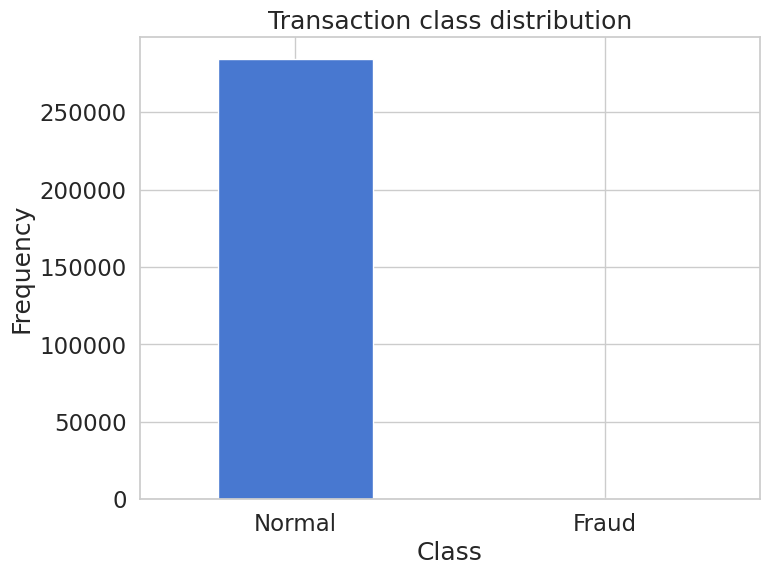

In [ ]:
plt.figure(figsize=(8,6))

count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")


In [ ]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
frauds.Amount.describe()

,Amount
count,492.000000
mean,122.211321
std,256.683288
min,0.000000
25%,1.000000
50%,9.250000
75%,105.890000
max,2125.870000


In [ ]:
normal.Amount.describe()

,Amount
count,284315.000000
mean,88.291022
std,250.105092
min,0.000000
25%,5.650000
50%,22.000000
75%,77.050000
max,25691.160000


# ⚛ Visualizing the amount for normal and fraud transactions.

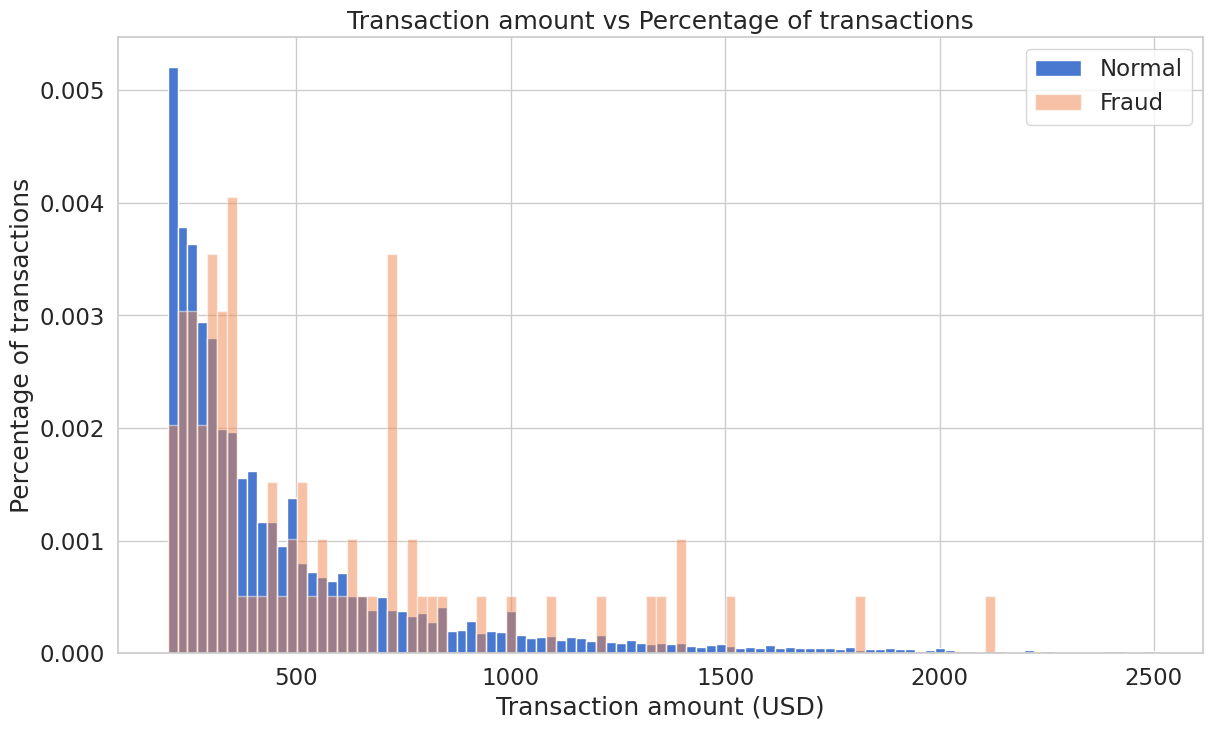

In [ ]:

#Visualize transaction amounts for normal and fraudulent transactions
bins = np.linspace(200, 2500, 100)
plt.hist(normal.Amount, bins=bins, alpha=1, density=True, label='Normal')
plt.hist(frauds.Amount, bins=bins, alpha=0.5, density=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Transaction amount vs Percentage of transactions")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions");
plt.show()

# ⚛ Autoencoders

In [ ]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [ ]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [ ]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
X_train.shape

(227451, 29)

# ⚛  Building the model

In [ ]:
input_dim = X_train.shape[1]
encoding_dim = 14


In [ ]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh",
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

# ⚛  model training on our database

In [ ]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
7090/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4856 - loss: 0.8888

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.4859 - loss: 0.8886 - val_accuracy: 0.6331 - val_loss: 0.7983
Epoch 2/100
7107/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6358 - loss: 0.7538

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.6358 - loss: 0.7538 - val_accuracy: 0.6396 - val_loss: 0.7921
Epoch 3/100
7094/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6399 - loss: 0.7709

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.6399 - loss: 0.7708 - val_accuracy: 0.6411 - val_loss: 0.7817
Epoch 4/100
7103/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6465 - loss: 0.7562

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - accuracy: 0.6465 - loss: 0.7562 - val_accuracy: 0.6559 - val_loss: 0.7779
Epoch 5/100
7107/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6515 - loss: 0.7484

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - accuracy: 0.6515 - loss: 0.7484 - val_accuracy: 0.6519 - val_loss: 0.7743
Epoch 6/100
7100/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6529 - loss: 0.7408

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.6529 - loss: 0.7408 - val_accuracy: 0.6574 - val_loss: 0.7717
Epoch 7/100
7094/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6561 - loss: 0.7540

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - accuracy: 0.6561 - loss: 0.7540 - val_accuracy: 0.6564 - val_loss: 0.7713
Epoch 8/100
7101/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6583 - loss: 0.7424

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.6583 - loss: 0.7424 - val_accuracy: 0.6626 - val_loss: 0.7703
Epoch 9/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.6572 - loss: 0.7539 - val_accuracy: 0.6578 - val_loss: 0.7722
Epoch 10/100
7102/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6563 - loss: 0.7394

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.6563 - loss: 0.7394 - val_accuracy: 0.6579 - val_loss: 0.7696
Epoch 11/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.6597 - loss: 0.7281 - val_accuracy: 0.6337 - val_loss: 0.7921
Epoch 12/100
7093/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6634 - loss: 0.7454

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.6634 - loss: 0.7453 - val_accuracy: 0.6601 - val_loss: 0.7659
Epoch 13/100
7107/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6605 - loss: 0.7279

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.6605 - loss: 0.7279 - val_accuracy: 0.6686 - val_loss: 0.7655
Epoch 14/100
7099/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6672 - loss: 0.7257

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.6672 - loss: 0.7257 - val_accuracy: 0.6631 - val_loss: 0.7636
Epoch 15/100
7095/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6664 - loss: 0.7241

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.6664 - loss: 0.7241 - val_accuracy: 0.6704 - val_loss: 0.7610
Epoch 16/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.6661 - loss: 0.7235 - val_accuracy: 0.6589 - val_loss: 0.7616
Epoch 17/100
7106/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6673 - loss: 0.7375

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.6673 - loss: 0.7375 - val_accuracy: 0.6698 - val_loss: 0.7594
Epoch 18/100
7093/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6684 - loss: 0.7154

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.6684 - loss: 0.7154 - val_accuracy: 0.6672 - val_loss: 0.7591
Epoch 19/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.6690 - loss: 0.7196 - val_accuracy: 0.6602 - val_loss: 0.7706
Epoch 20/100
7087/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6701 - loss: 0.7208

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.6701 - loss: 0.7208 - val_accuracy: 0.6627 - val_loss: 0.7585
Epoch 21/100
7086/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6694 - loss: 0.7161

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.6694 - loss: 0.7161 - val_accuracy: 0.6618 - val_loss: 0.7574
Epoch 22/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.6688 - loss: 0.7211 - val_accuracy: 0.6708 - val_loss: 0.7593
Epoch 23/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - accuracy: 0.6703 - loss: 0.7294 - val_accuracy: 0.6695 - val_loss: 0.7583
Epoch 24/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.6696 - loss: 0.7289 - val_accuracy: 0.6711 - val_loss: 0.7576
Epoch 25/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.6683 - loss: 0.7184 - val_accuracy: 0.6631 - val_loss: 0.7584
Epoch 26/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.6700 - loss: 0.7316 - val_accuracy: 0.6576 - val_loss: 0.7590
Epoch 27/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.6712 - loss: 0.7172 - val_accuracy: 0.6658 - val_loss: 0.7579
Epoch 28/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.6703 - loss

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.6697 - loss: 0.7190 - val_accuracy: 0.6736 - val_loss: 0.7564
Epoch 30/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - accuracy: 0.6713 - loss: 0.7243 - val_accuracy: 0.6700 - val_loss: 0.7578
Epoch 31/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.6687 - loss: 0.7262 - val_accuracy: 0.6675 - val_loss: 0.7575
Epoch 32/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - accuracy: 0.6701 - loss: 0.7044 - val_accuracy: 0.6667 - val_loss: 0.7579
Epoch 33/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.6699 - loss: 0.7194 - val_accuracy: 0.6691 - val_loss: 0.7574
Epoch 34/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - accuracy: 0.6719 - loss: 0.7117 - val_accuracy: 0.6712 - val_loss: 0.7567
Epoch 35/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.6698 - loss: 0.7200 - val_accuracy: 0.6622 - val_loss: 0.7579
Epoch 36/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.6714 - loss

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.6697 - loss: 0.7144 - val_accuracy: 0.6790 - val_loss: 0.7556
Epoch 44/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.6714 - loss: 0.7105 - val_accuracy: 0.6690 - val_loss: 0.7566
Epoch 45/100
7107/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6693 - loss: 0.7148

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.6693 - loss: 0.7148 - val_accuracy: 0.6704 - val_loss: 0.7549
Epoch 46/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - accuracy: 0.6690 - loss: 0.7103 - val_accuracy: 0.6685 - val_loss: 0.7565
Epoch 47/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - accuracy: 0.6677 - loss: 0.7225 - val_accuracy: 0.6634 - val_loss: 0.7611
Epoch 48/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.6695 - loss: 0.7217 - val_accuracy: 0.6743 - val_loss: 0.7583
Epoch 49/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.6683 - loss: 0.7173 - val_accuracy: 0.6579 - val_loss: 0.7639
Epoch 50/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.6701 - loss: 0.7121 - val_accuracy: 0.6739 - val_loss: 0.7616
Epoch 51/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - accuracy: 0.6697 - loss: 0.7224 - val_accuracy: 0.6811 - val_loss: 0.7552
Epoch 52/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.6695 - loss

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.6728 - loss: 0.7101 - val_accuracy: 0.6753 - val_loss: 0.7547
Epoch 57/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.6737 - loss: 0.7243 - val_accuracy: 0.6757 - val_loss: 0.7582
Epoch 58/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.6751 - loss: 0.7283 - val_accuracy: 0.6631 - val_loss: 0.7602
Epoch 59/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.6727 - loss: 0.7146 - val_accuracy: 0.6571 - val_loss: 0.7569
Epoch 60/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.6741 - loss: 0.7303 - val_accuracy: 0.6674 - val_loss: 0.7594
Epoch 61/100
7089/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6741 - loss: 0.7194

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.6741 - loss: 0.7194 - val_accuracy: 0.6803 - val_loss: 0.7539
Epoch 62/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.6753 - loss: 0.7075 - val_accuracy: 0.6780 - val_loss: 0.7577
Epoch 63/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.6738 - loss: 0.7153 - val_accuracy: 0.6716 - val_loss: 0.7596
Epoch 64/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - accuracy: 0.6738 - loss: 0.7422 - val_accuracy: 0.6850 - val_loss: 0.7551
Epoch 65/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.6759 - loss: 0.7152 - val_accuracy: 0.6707 - val_loss: 0.7575
Epoch 66/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.6769 - loss: 0.7228 - val_accuracy: 0.6779 - val_loss: 0.7554
Epoch 67/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - accuracy: 0.6766 - loss: 0.7126 - val_accuracy: 0.6756 - val_loss: 0.7577
Epoch 68/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - accuracy: 0.6782 - loss

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step - accuracy: 0.6753 - loss: 0.7296 - val_accuracy: 0.6803 - val_loss: 0.7535
Epoch 72/100
7107/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6771 - loss: 0.7445

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.6771 - loss: 0.7445 - val_accuracy: 0.6794 - val_loss: 0.7527
Epoch 73/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.6771 - loss: 0.7344 - val_accuracy: 0.6515 - val_loss: 0.7629
Epoch 74/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.6768 - loss: 0.7205 - val_accuracy: 0.6712 - val_loss: 0.7560
Epoch 75/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.6769 - loss: 0.7127 - val_accuracy: 0.6407 - val_loss: 0.7640
Epoch 76/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.6771 - loss: 0.7195 - val_accuracy: 0.6853 - val_loss: 0.7531
Epoch 77/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.6775 - loss: 0.7174 - val_accuracy: 0.6649 - val_loss: 0.7629
Epoch 78/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.6780 - loss: 0.7206 - val_accuracy: 0.6799 - val_loss: 0.7537
Epoch 79/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.6765 - loss

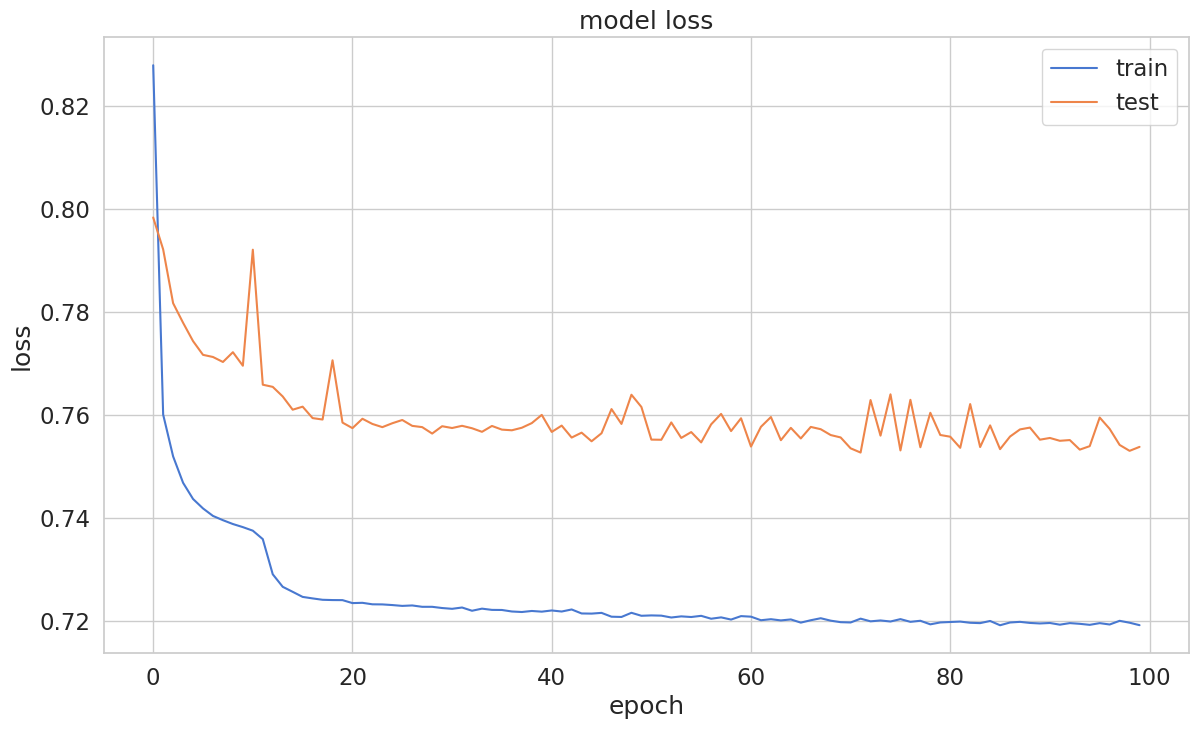

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [ ]:
predictions = autoencoder.predict(X_test)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [ ]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [ ]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.744516,0.001720
std,3.395460,0.041443
min,0.067834,0.000000
25%,0.254473,0.000000
50%,0.396175,0.000000
75%,0.616498,0.000000
max,262.984277,1.000000


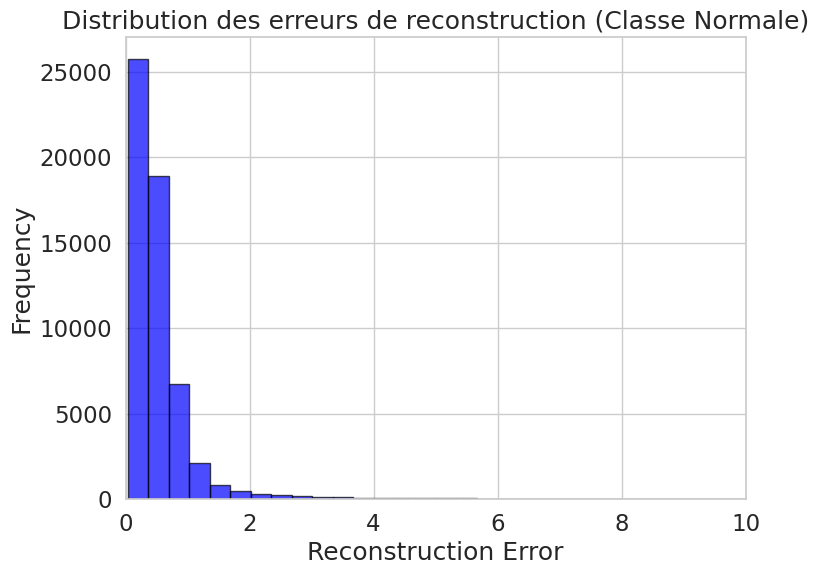

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# Filtrer les erreurs de reconstruction pour les transactions normales
normal_error_df = error_df[(error_df['true_class'] == 0) & (error_df['reconstruction_error'] < 10)]

# Histogramme avec plus de bins et alpha pour la transparence
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=30, alpha=0.7, color="blue", edgecolor="black")

# Ajuster les axes
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Distribution des erreurs de reconstruction (Classe Normale)")
plt.xlim(0, 10)  # Ajuster selon les valeurs réelles
plt.grid(True)

plt.show()


In [ ]:
normal_error_df.describe()


In [ ]:
fraud_error_df.describe()

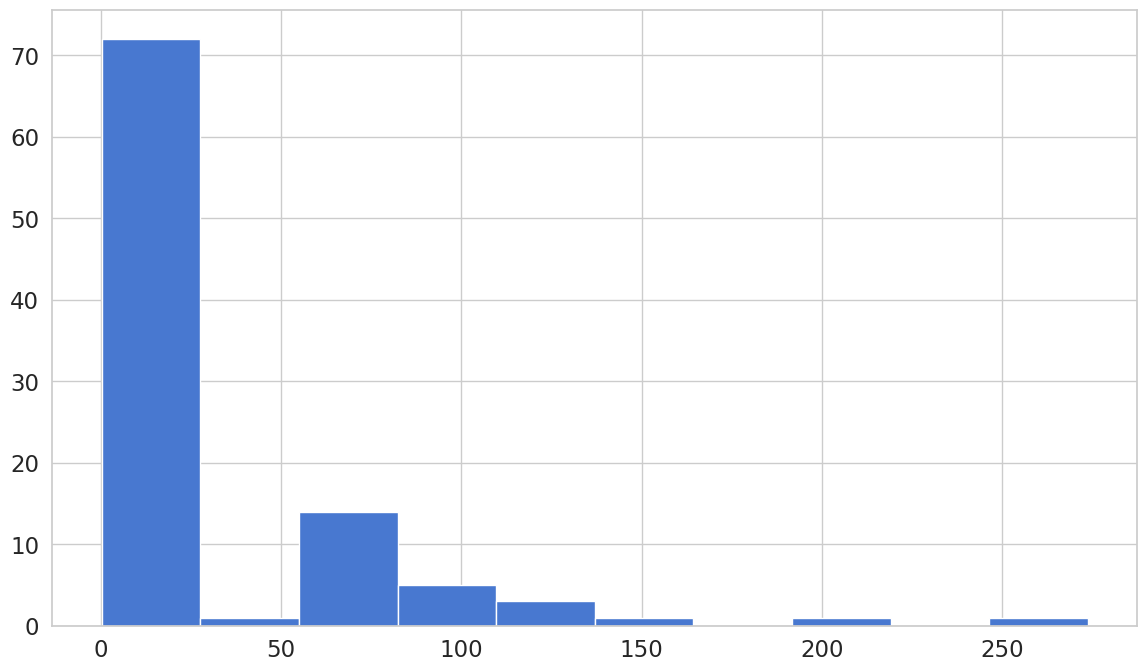

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [ ]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

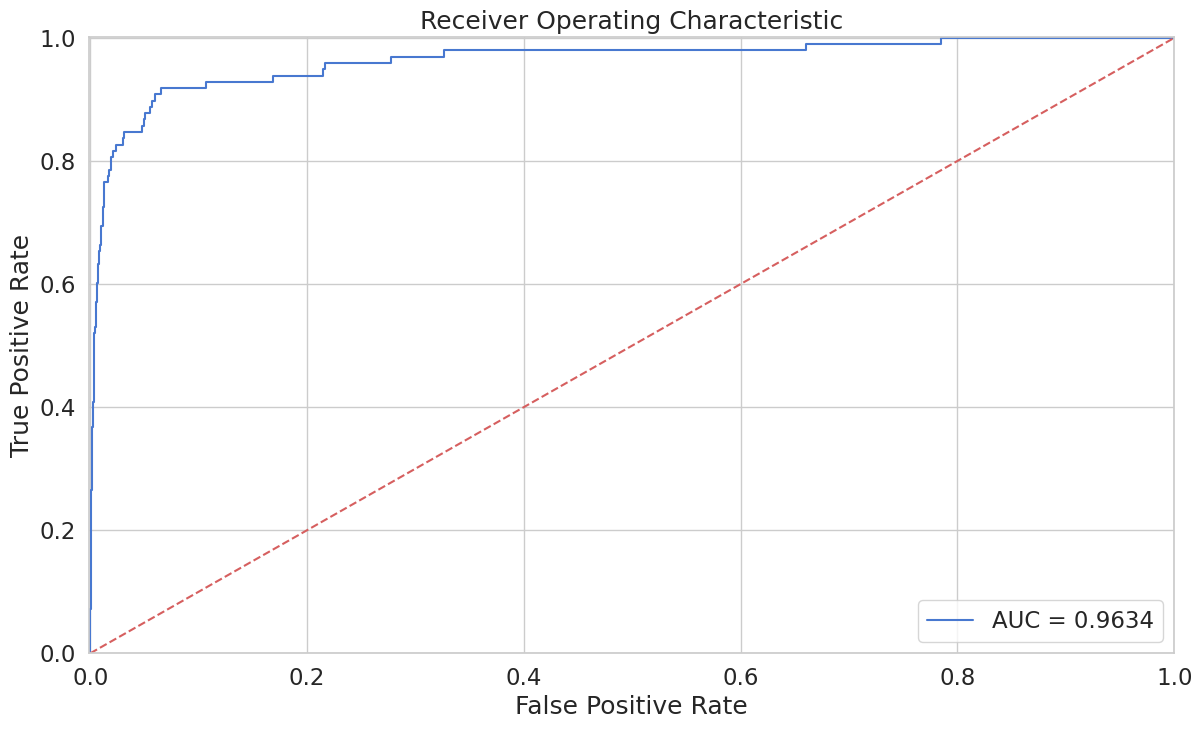

In [ ]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

# ⚛ Recall vs Precision

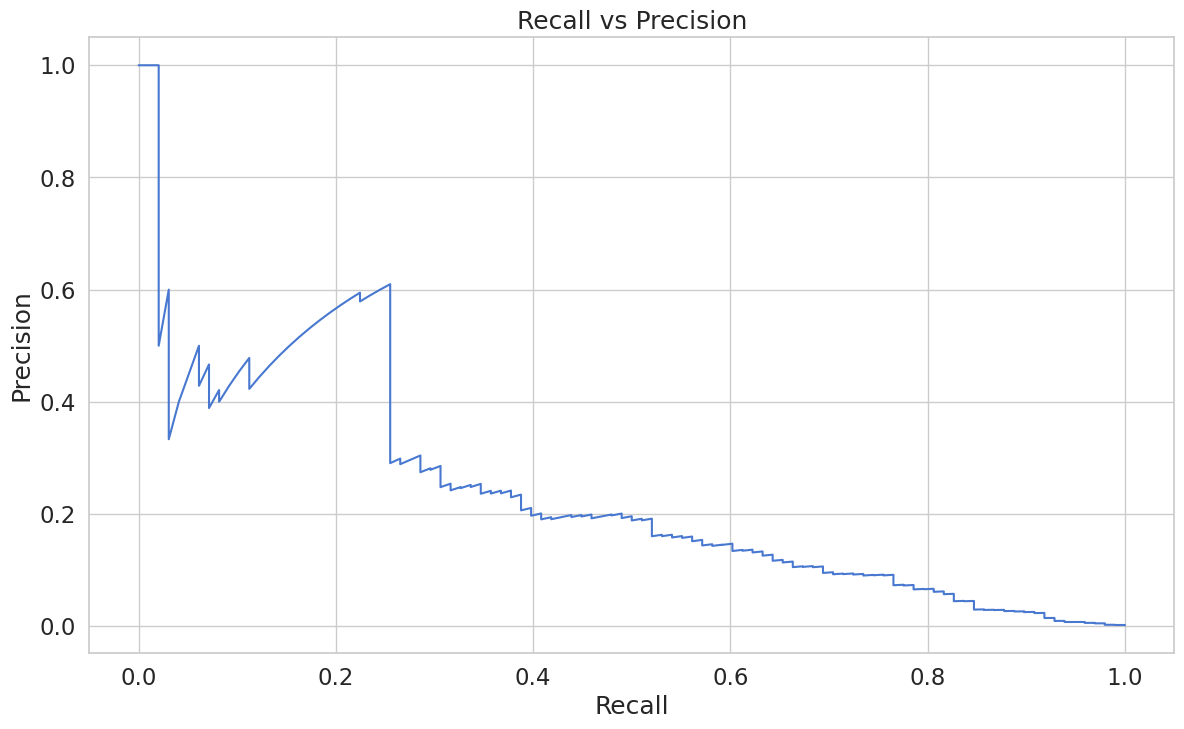

In [ ]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

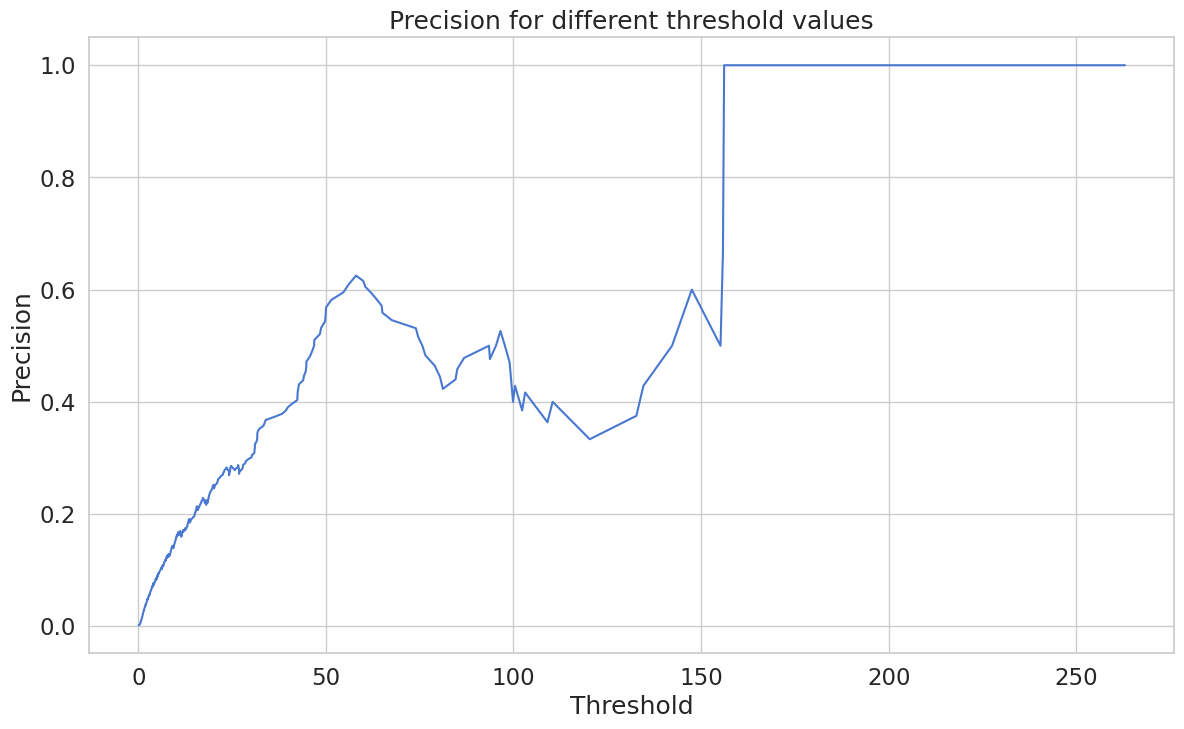

In [ ]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

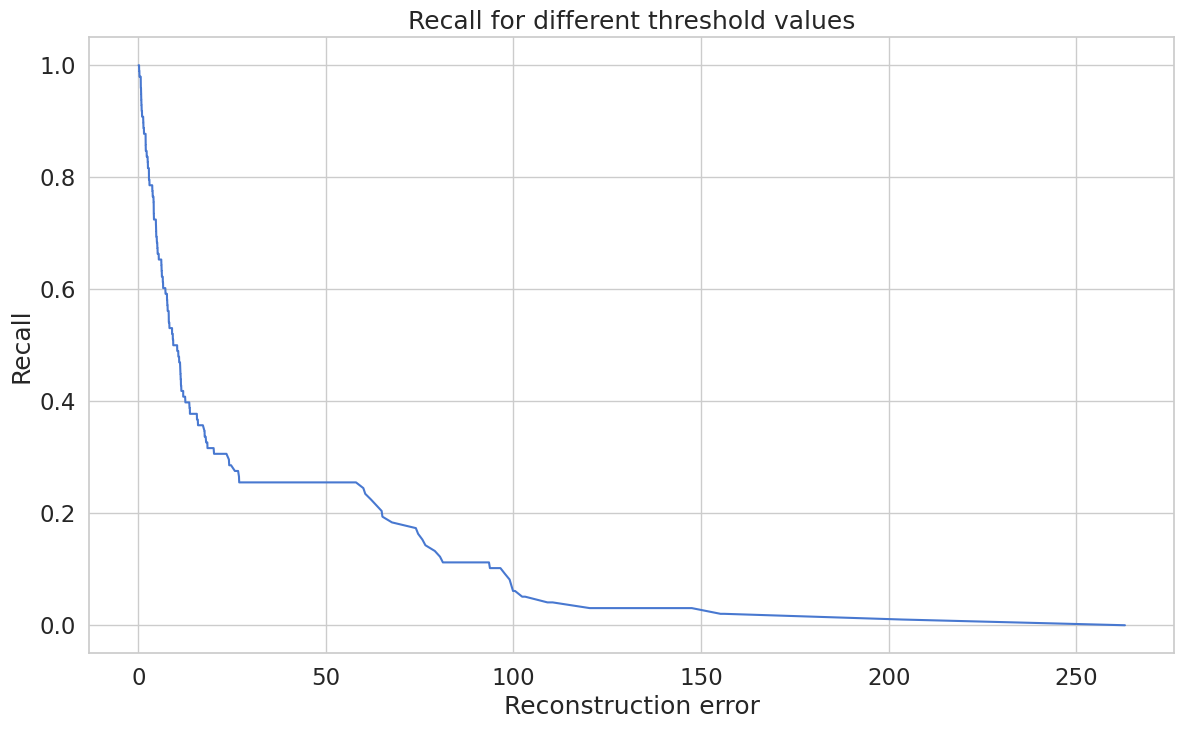

In [ ]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

## ⚛ Detect Anomalies on test **data**

In [ ]:
threshold = 2.9

Text(0.5, 0, 'Data point index')

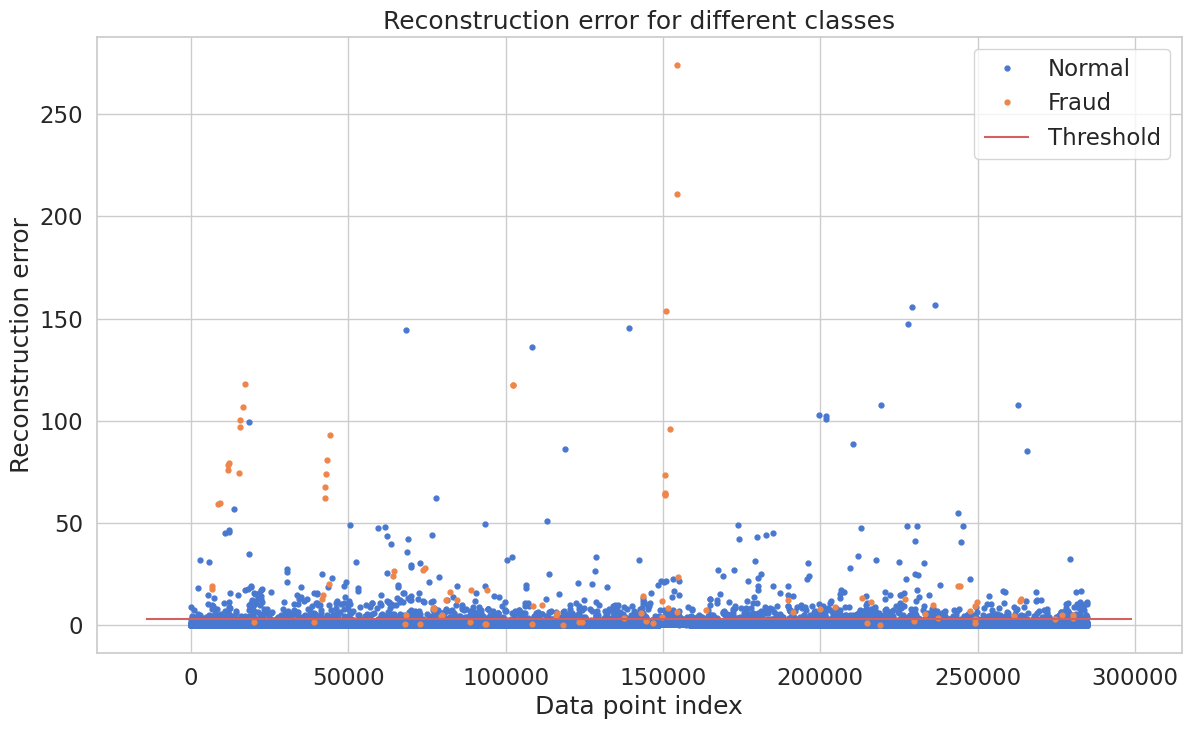

In [ ]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")

# 📌 Deepautoencoder

In [ ]:
input_layer = Input(shape=(input_dim,))

encoder = Dense(64, activation="relu")(input_layer)
encoder = Dense(32, activation="relu")(encoder)
encoder = Dense(8, activation="relu")(encoder)  # Bottleneck layer

# Decoder
decoder = Dense(16, activation="relu")(encoder)
decoder = Dense(32, activation="relu")(decoder)
decoder = Dense(input_dim, activation="sigmoid")(decoder)
Deepautoencoder = Model(inputs=input_layer, outputs=decoder)

In [ ]:
nb_epoch = 50
batch_size = 32

Deepautoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = Deepautoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
7104/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4884 - loss: 0.8910

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.4885 - loss: 0.8909 - val_accuracy: 0.5988 - val_loss: 0.8568
Epoch 2/100
7100/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6020 - loss: 0.8405

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.6020 - loss: 0.8405 - val_accuracy: 0.5907 - val_loss: 0.8369
Epoch 3/100
7103/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5868 - loss: 0.8094

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.5868 - loss: 0.8094 - val_accuracy: 0.5794 - val_loss: 0.8252
Epoch 4/100
7094/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5763 - loss: 0.7699

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.5763 - loss: 0.7699 - val_accuracy: 0.5804 - val_loss: 0.8212
Epoch 5/100
7099/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5840 - loss: 0.7769

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.5840 - loss: 0.7769 - val_accuracy: 0.5839 - val_loss: 0.8152
Epoch 6/100
7106/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5861 - loss: 0.7976

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.5861 - loss: 0.7975 - val_accuracy: 0.5922 - val_loss: 0.8129
Epoch 7/100
7090/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5916 - loss: 0.8031

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.5916 - loss: 0.8030 - val_accuracy: 0.6138 - val_loss: 0.8125
Epoch 8/100
7102/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6092 - loss: 0.7807

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.6092 - loss: 0.7807 - val_accuracy: 0.6191 - val_loss: 0.8092
Epoch 9/100
7099/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6124 - loss: 0.7923

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6125 - loss: 0.7922 - val_accuracy: 0.6173 - val_loss: 0.8086
Epoch 10/100
7092/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6254 - loss: 0.7811

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.6254 - loss: 0.7811 - val_accuracy: 0.6303 - val_loss: 0.8072
Epoch 11/100
7093/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6255 - loss: 0.7878

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.6255 - loss: 0.7878 - val_accuracy: 0.6309 - val_loss: 0.8067
Epoch 12/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.6301 - loss: 0.7929 - val_accuracy: 0.6315 - val_loss: 0.8085
Epoch 13/100
7103/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6350 - loss: 0.7884

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.6350 - loss: 0.7884 - val_accuracy: 0.6391 - val_loss: 0.8060
Epoch 14/100
7101/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6362 - loss: 0.7881

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.6362 - loss: 0.7881 - val_accuracy: 0.6403 - val_loss: 0.8046
Epoch 15/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.6375 - loss: 0.7760 - val_accuracy: 0.6438 - val_loss: 0.8052
Epoch 16/100
7093/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6257 - loss: 0.7839

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.6257 - loss: 0.7839 - val_accuracy: 0.6310 - val_loss: 0.8044
Epoch 17/100
7094/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6262 - loss: 0.7959

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.6262 - loss: 0.7959 - val_accuracy: 0.6263 - val_loss: 0.8036
Epoch 18/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.6219 - loss: 0.7926 - val_accuracy: 0.6178 - val_loss: 0.8037
Epoch 19/100
7106/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6204 - loss: 0.7866

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.6204 - loss: 0.7866 - val_accuracy: 0.6305 - val_loss: 0.8022
Epoch 20/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.6228 - loss: 0.7702 - val_accuracy: 0.6177 - val_loss: 0.8038
Epoch 21/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.6248 - loss: 0.8040 - val_accuracy: 0.6273 - val_loss: 0.8027
Epoch 22/100
7097/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6240 - loss: 0.7763

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.6240 - loss: 0.7763 - val_accuracy: 0.6242 - val_loss: 0.8021
Epoch 23/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.6259 - loss: 0.8111 - val_accuracy: 0.6155 - val_loss: 0.8030
Epoch 24/100
7099/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6245 - loss: 0.7657

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - accuracy: 0.6245 - loss: 0.7657 - val_accuracy: 0.6239 - val_loss: 0.8017
Epoch 25/100
7105/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6261 - loss: 0.7767

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.6261 - loss: 0.7767 - val_accuracy: 0.6324 - val_loss: 0.8012
Epoch 26/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.6234 - loss: 0.7751 - val_accuracy: 0.6279 - val_loss: 0.8012
Epoch 27/100
7102/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6252 - loss: 0.7668

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.6252 - loss: 0.7668 - val_accuracy: 0.6301 - val_loss: 0.8005
Epoch 28/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.6264 - loss: 0.7613 - val_accuracy: 0.6269 - val_loss: 0.8005
Epoch 29/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - accuracy: 0.6219 - loss: 0.7698 - val_accuracy: 0.6259 - val_loss: 0.8006
Epoch 30/100
7106/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6219 - loss: 0.7761

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.6219 - loss: 0.7761 - val_accuracy: 0.6203 - val_loss: 0.7975
Epoch 31/100
7101/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6188 - loss: 0.7828

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - accuracy: 0.6188 - loss: 0.7828 - val_accuracy: 0.6184 - val_loss: 0.7972
Epoch 32/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.6150 - loss: 0.7775 - val_accuracy: 0.6076 - val_loss: 0.7976
Epoch 33/100
7091/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6143 - loss: 0.7644

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - accuracy: 0.6143 - loss: 0.7645 - val_accuracy: 0.6087 - val_loss: 0.7963
Epoch 34/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.6131 - loss: 0.7648 - val_accuracy: 0.6198 - val_loss: 0.7964
Epoch 35/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6122 - loss: 0.7759 - val_accuracy: 0.6075 - val_loss: 0.7965
Epoch 36/100
7103/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6098 - loss: 0.7667

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - accuracy: 0.6098 - loss: 0.7667 - val_accuracy: 0.6156 - val_loss: 0.7951
Epoch 37/100
7091/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6068 - loss: 0.7822

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.6068 - loss: 0.7822 - val_accuracy: 0.6011 - val_loss: 0.7949
Epoch 38/100
7099/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6046 - loss: 0.7509

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.6046 - loss: 0.7510 - val_accuracy: 0.6192 - val_loss: 0.7943
Epoch 39/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.6093 - loss: 0.7500 - val_accuracy: 0.6108 - val_loss: 0.7951
Epoch 40/100
7094/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6106 - loss: 0.7578

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6106 - loss: 0.7578 - val_accuracy: 0.6370 - val_loss: 0.7937
Epoch 41/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.6139 - loss: 0.7684 - val_accuracy: 0.6145 - val_loss: 0.7939
Epoch 42/100
7107/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6168 - loss: 0.7534

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.6168 - loss: 0.7534 - val_accuracy: 0.6081 - val_loss: 0.7934
Epoch 43/100
7101/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6080 - loss: 0.7769

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.6080 - loss: 0.7769 - val_accuracy: 0.5889 - val_loss: 0.7933
Epoch 44/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.6104 - loss: 0.7758 - val_accuracy: 0.6016 - val_loss: 0.7947
Epoch 45/100
7104/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6100 - loss: 0.7621

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.6100 - loss: 0.7621 - val_accuracy: 0.6245 - val_loss: 0.7929
Epoch 46/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.6085 - loss: 0.7635 - val_accuracy: 0.6096 - val_loss: 0.7991
Epoch 47/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.6027 - loss: 0.7803 - val_accuracy: 0.6195 - val_loss: 0.7941
Epoch 48/100
7103/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6040 - loss: 0.7556

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - accuracy: 0.6040 - loss: 0.7556 - val_accuracy: 0.6081 - val_loss: 0.7927
Epoch 49/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.6012 - loss: 0.7648 - val_accuracy: 0.6097 - val_loss: 0.7929
Epoch 50/100
7098/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6079 - loss: 0.7623

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.6079 - loss: 0.7623 - val_accuracy: 0.6034 - val_loss: 0.7922
Epoch 51/100
7100/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6060 - loss: 0.7602

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.6060 - loss: 0.7602 - val_accuracy: 0.6006 - val_loss: 0.7915
Epoch 52/100
7089/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6083 - loss: 0.7574

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.6083 - loss: 0.7574 - val_accuracy: 0.6057 - val_loss: 0.7913
Epoch 53/100
7090/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6060 - loss: 0.7574

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.6060 - loss: 0.7575 - val_accuracy: 0.6054 - val_loss: 0.7912
Epoch 54/100
7091/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6093 - loss: 0.7579

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - accuracy: 0.6093 - loss: 0.7579 - val_accuracy: 0.6148 - val_loss: 0.7910
Epoch 55/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.6063 - loss: 0.7686 - val_accuracy: 0.6089 - val_loss: 0.7917
Epoch 56/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.6084 - loss: 0.7580 - val_accuracy: 0.5989 - val_loss: 0.7918
Epoch 57/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.6032 - loss: 0.7679 - val_accuracy: 0.6048 - val_loss: 0.7981
Epoch 58/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.6093 - loss: 0.7668 - val_accuracy: 0.6145 - val_loss: 0.7910
Epoch 59/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.6055 - loss: 0.7582 - val_accuracy: 0.6129 - val_loss: 0.7949
Epoch 60/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.6054 - loss: 0.7591 - val_accuracy: 0.6025 - val_loss: 0.7917
Epoch 61/100
7089/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6067 - loss:

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.6067 - loss: 0.7517 - val_accuracy: 0.6046 - val_loss: 0.7907
Epoch 62/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.6050 - loss: 0.7529 - val_accuracy: 0.6011 - val_loss: 0.7915
Epoch 63/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6052 - loss: 0.7712 - val_accuracy: 0.6101 - val_loss: 0.7939
Epoch 64/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.6097 - loss: 0.7770 - val_accuracy: 0.6051 - val_loss: 0.7940
Epoch 65/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.6086 - loss: 0.7739 - val_accuracy: 0.5980 - val_loss: 0.7908
Epoch 66/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.6082 - loss: 0.7631 - val_accuracy: 0.6027 - val_loss: 0.7919
Epoch 67/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.6082 - loss: 0.7520 - val_accuracy: 0.6121 - val_loss: 0.7910
Epoch 68/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6083 - loss:

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.6083 - loss: 0.7694 - val_accuracy: 0.6151 - val_loss: 0.7906
Epoch 69/100
7099/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6078 - loss: 0.7541

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.6078 - loss: 0.7541 - val_accuracy: 0.6065 - val_loss: 0.7899
Epoch 70/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.6068 - loss: 0.7836 - val_accuracy: 0.6079 - val_loss: 0.7902
Epoch 71/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - accuracy: 0.6165 - loss: 0.7607 - val_accuracy: 0.6115 - val_loss: 0.7907
Epoch 72/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.6112 - loss: 0.7806 - val_accuracy: 0.6276 - val_loss: 0.7909
Epoch 73/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.6115 - loss: 0.7616 - val_accuracy: 0.6173 - val_loss: 0.7902
Epoch 74/100
7093/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6133 - loss: 0.7502

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6133 - loss: 0.7503 - val_accuracy: 0.6162 - val_loss: 0.7897
Epoch 75/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.6135 - loss: 0.7623 - val_accuracy: 0.6087 - val_loss: 0.7908
Epoch 76/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.6173 - loss: 0.7724 - val_accuracy: 0.6301 - val_loss: 0.7906
Epoch 77/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.6229 - loss: 0.7551 - val_accuracy: 0.6327 - val_loss: 0.7900
Epoch 78/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.6185 - loss: 0.7504 - val_accuracy: 0.6106 - val_loss: 0.7911
Epoch 79/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.6146 - loss: 0.7691 - val_accuracy: 0.6171 - val_loss: 0.7913
Epoch 80/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.6143 - loss: 0.7673 - val_accuracy: 0.6121 - val_loss: 0.7902
Epoch 81/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - accuracy: 0.6164 - loss

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.6102 - loss: 0.7796 - val_accuracy: 0.6173 - val_loss: 0.7894
Epoch 86/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.6106 - loss: 0.7593 - val_accuracy: 0.6160 - val_loss: 0.7905
Epoch 87/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.6091 - loss: 0.7749 - val_accuracy: 0.6148 - val_loss: 0.7912
Epoch 88/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.6128 - loss: 0.7658 - val_accuracy: 0.6186 - val_loss: 0.7900
Epoch 89/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.6095 - loss: 0.7455 - val_accuracy: 0.6044 - val_loss: 0.7912
Epoch 90/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.6035 - loss: 0.7597 - val_accuracy: 0.6114 - val_loss: 0.7900
Epoch 91/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.6049 - loss: 0.7832 - val_accuracy: 0.6097 - val_loss: 0.7910
Epoch 92/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.6159 - loss

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.6218 - loss: 0.7460 - val_accuracy: 0.6303 - val_loss: 0.7894
Epoch 100/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.6240 - loss: 0.7605 - val_accuracy: 0.6242 - val_loss: 0.7895


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


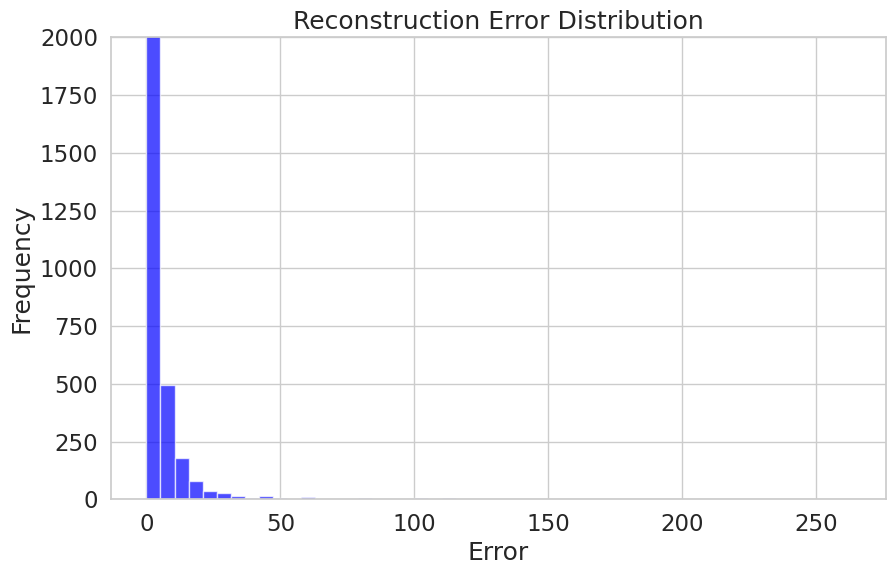

In [ ]:
predictions = Deepautoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
import matplotlib.pyplot as plt

# Plot histogram of errors
plt.figure(figsize=(10,6))

plt.hist(mse, bins=50, alpha=0.7, color='blue')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.ylim(0, 2000)  # Augmentez la limite supérieure selon vos besoins

plt.show()


In [ ]:
threshold = 58.453308635779415

# Prédire la classe (fraude si mse > threshold)
y_pred = (mse > threshold).astype(int)

# Afficher la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :\n", conf_matrix)

# Rapport de classification
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Matrice de confusion :
 [[56842    22]
 [   73    25]]
Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.53      0.26      0.34        98

    accuracy                           1.00     56962
   macro avg       0.77      0.63      0.67     56962
weighted avg       1.00      1.00      1.00     56962



In [ ]:
from sklearn.metrics import f1_score

best_threshold = None
best_f1 = 0

for threshold in np.linspace(mse.min(), mse.max(), 100):
    y_pred = (mse > threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Meilleur seuil : {best_threshold}, Meilleur F1-score : {best_f1}")


Meilleur seuil : 58.453308635779415, Meilleur F1-score : 0.3448275862068966
